<a href="https://colab.research.google.com/github/alqamahsayeed12/Air-Quality-Trainings/blob/Module-2/Module_2_Ground_Measurements_OpenAQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MODULE-2 Ground Monitor data by OpenAQ**

Note - OpenAQ is A data aggregator


**MÓDULO-2 Datos del monitor de tierra por OpenAQ**

Nota - OpenAQ es un agregador de datos

Website:  https://openaq.org/

API Instructions: https://api.openaq.org/docs#/

API Account:  https://explore.openaq.org/account


Quick Start Guide - https://docs.openaq.org/using-the-api/quick-start

API Key - fc1fed0fc9392487d52862b2b367c9ab17df291d9095ec7b98c32675bc106358

This script retrieves and analyzes air quality data from the OpenAQ platform.

The script performs the following steps:

1. Installs necessary libraries: cartopy for mapping.
2. Imports required libraries for data handling, visualization, and geographical analysis.
3. Mounts Google Drive for data storage and retrieval.
4. Sets basic settings for the analysis, including geographical boundaries, date range, and API key.
5. Defines functions for fetching data from the OpenAQ API and plotting data on maps.
6. Retrieves air quality data for a specified pollutant (e.g., PM25, PM10) and time period using the defined functions.
7. Saves the retrieved data to a CSV file.
8. Calculates and displays the average pollutant concentration for each location.
9. Generates maps to visualize the spatial distribution of pollutant concentrations.
10. Plots time series of pollutant concentrations for specific locations.

Dependencies:
- pandas
- os
- sys
- datetime
- urllib
- json
- matplotlib
- requests
- numpy
- cartopy
- seaborn
- geopy

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 30.2 MB/s eta 0:00:00


In [ ]:
# imports
import pandas as pd
import os
import sys
from datetime import datetime
from os.path import expanduser
import urllib
import urllib.request
import json
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import requests
import matplotlib as mpl

import numpy as np
# import geopandas as gpd
import cartopy
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader
import warnings
import time
import seaborn as sns  # Import Seaborn for styling

from geopy.geocoders import Nominatim # This line imports Nominatim
import matplotlib.dates as mdates # This line imports the 'dates' submodule from 'matplotlib'


warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
NEED_PIP_INSTALL = True # set true first time run

Mounted at /content/drive


**Basic Settings**
Decide whether to use pre-filled settings specified below in the code.

1.   If True, pre-filled settings are used.
2.   If False, null values are used, and users are asked to specify inputs in the following section.

Any values may be set to None, and the user will be asked to provide the requested input in the next section.

In [ ]:
PRE_FILL_SETTINGS = True ## or False
if PRE_FILL_SETTINGS:
  ## Bounds for the analysis area and period:

  # Maximum Latitude:
  lat_max = 60.0

  # Maximum Longitude:
  lon_max = -30.0

  # Minumum Latitude:
  lat_min = -15.0

  # Minimum Longitude:
  lon_min = -150.0

  # Start Date and Time:
  start = pd.to_datetime('2024-10-01 00:00:00')
  # End Date and Time:
  end = pd.to_datetime('2024-10-10 23:59:59')


  ## AQS API Login Information:
  api_key = "fc1fed0fc9392487d52862b2b367c9ab17df291d9095ec7b98c32675bc106358"

  # data has previously been downloaded and saved in google drive:
  PREDOWNLOAD = False
  # download and save datasets:

  SAVEDATA = True

  # load/save data from Google Drive:
  GDRIVE = True
  # path to use for loading/saving data:

  data_path = '/content/drive/MyDrive/Guatemala_Training/OPENAQ_DATA/'
  if not os.path.exists(data_path):
        os.makedirs(data_path)

else:
  lat_max = None;
  lon_max = None;
  lat_min = None;
  lon_min = None;
  start = None;
  end = None;

  api_key = None;
  CLOUD = None;
  PREDOWNLOAD = None;
  SAVEDATA = None;
  GDRIVE = None;
  data_path = None;

# Save the data access options for future reference:
d_data_access_options = {
                         'PREDOWNLOAD':PREDOWNLOAD,
                         'SAVEDATA':SAVEDATA,
                         'GDRIVE':GDRIVE,
                         'data_path':data_path
                         }

This section of the code is designed to set up the parameters for your air quality data analysis. It does this by:

**Defining the Analysis Area:** It asks you to specify the geographical boundaries of the area you're interested in by providing the maximum and minimum latitude and longitude values. It also prompts you to enter the start and end dates for the analysis period.

**Providing API Key:** You'll need an API key to access data from the OpenAQ platform. The code will ask you to enter your key if it's not already provided.

**Setting Data Access Options:** This part helps you manage how the data is handled. You'll be asked if you've previously downloaded the datasets, if you want to save the data for later use, and if you prefer to store it in your Google Drive. Based on your responses, the code will guide you through providing the necessary information like the data path.

In [ ]:
## Definition of the analysis domain:
if lat_max is None:
  lat_max = input('Please enter a maximum latitude to define the domain of interest:\n')
if lat_min is None:
  lat_min = input('Please enter a minimum latitude to define the domain of interest:\n')
if lon_max is None:
  lon_max = input('Please enter a maximum longitude to define the domain of interest:\n')
if lon_min is None:
  lon_min = input('Please enter a minimum longitude to define the domain of interest:\n')
if start is None:
  start = input('Please enter a start date and time (UTC) for the analysis.\nRequired format: YYYY-MM-DD hh:mm:s\n')
  start = pd.to_datetime(start)
if end is None:
  end = input('Please enter an end date and time (UTC) for the analysis.\nRequired format: YYYY-MM-DD hh:mm:s\n')
  end = pd.to_datetime(end)


## OpenAQ login information:
if api_key is None:
  api_key = input('Please enter your EPA AQS API key:\n')

##  Data Access options:
def f_y_n_prompt(s_prompt):
  b_output = None
  while b_output is None:
    s_q_a = input(s_prompt).strip()
    if (s_q_a == 'Y') or (s_q_a == 'y') or (s_q_a == 'YES') or(s_q_a == 'Yes') or (s_q_a == 'yes'):
      b_output = True;
    elif (s_q_a == 'N') or (s_q_a == 'n') or (s_q_a == 'NO') or(s_q_a == 'No') or (s_q_a == 'no'):
      b_output = False;
  return b_output
if PREDOWNLOAD is None:
  PREDOWNLOAD = f_y_n_prompt('Have you previously downloaded the datasets you wish to analyze? (Y/N)\n')
if PREDOWNLOAD:
  if GDRIVE is None:
    GDRIVE = f_y_n_prompt('Are the data to be analyzed saved in Google Drive? (Y/N)\n')
  if GDRIVE:
    drive.mount('/content/drive')
    if data_path is None:
      data_path = input('Please enter the path to the folder with the data in Google Drive:\nExample:"/content/drive/MyDrive/Data"\n')
  else:
    if data_path is None:
      data_path = input('Please enter the path to the folder with the data:\n')
else:
  if SAVEDATA is None:
    SAVEDATA = f_y_n_prompt('Do you wish to save data for later analysis (Y/N)\nNote: If you choose "N", data will be temporarily downloaded and then deleted when it is no longer needed.\n')
  if SAVEDATA:
    if GDRIVE is None:
      GDRIVE = f_y_n_prompt('Do you wish to save the data to Google Drive? (Y/N)\n')
    if GDRIVE:
      drive.mount('/content/drive')
      if data_path is None:
        data_path = input('Please enter the path to the folder to save data to in Google Drive:\nExample:"/content/drive/MyDrive/Data"\n')
    else:
      if data_path is None:
        data_path = input('Please enter the path to the folder to save data to:\n')

# Save the data access options for future reference:
d_data_access_options = {
                         'PREDOWNLOAD':PREDOWNLOAD,
                         'SAVEDATA':SAVEDATA,
                         'GDRIVE':GDRIVE,
                         'data_path':data_path
                         }

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Enhancing Data with Location Details**
The following code defines a function called get_nearest_city_df. This function is designed to enrich your air quality data by adding information about the nearest city and country for each data point. It leverages the latitude and longitude coordinates in your data to perform reverse geocoding, which essentially means converting coordinates into meaningful location names.

**How it Works:**

**Input:** The function takes a Pandas DataFrame containing latitude and longitude columns as input.

**Geocoding:** It utilizes the Nominatim geocoder from the geopy library to identify the nearest city and country based on the provided coordinates.

**Adding Columns**: It adds two new columns to the DataFrame: 'Nearest_City' and 'Country', populating them with the retrieved location information.

**Output:** The function returns the modified DataFrame with the added location details.
By using this function, you can enhance your air quality data with valuable location context, making it easier to understand and analyze spatial patterns in air quality. This enriched data can be particularly helpful for visualizing air quality trends on maps or for exploring relationships between air quality and specific geographical areas.

In [ ]:
def get_nearest_city_df(df, latitude_col='Latitude', longitude_col='Longitude'):
  """
  Fetches the nearest city and country for each row in a Pandas DataFrame.

  Args:
    df: The Pandas DataFrame containing latitude and longitude columns.
    latitude_col: The name of the latitude column (default: 'Latitude').
    longitude_col: The name of the longitude column (default: 'Longitude').

  Returns:
    The DataFrame with added columns 'Nearest_City' and 'Country'.
  """
  geolocator = Nominatim(user_agent="city_finder")

  def get_city_country(row):
    latitude = row[latitude_col]
    longitude = row[longitude_col]
    location = geolocator.reverse((latitude, longitude), exactly_one=True)

    if location:
      address = location.raw['address']
      city = address.get('city')
      town = address.get('town')
      village = address.get('village')
      country = address.get('country')

      nearest_city = city or town or village
      return nearest_city, country
    else:
      return None, None

  df[['Nearest_City', 'Country']] = df.apply(get_city_country, axis=1, result_type="expand")
  return df

# **Retrieving Air Quality Data from OpenAQ**
This section defines a function called get_openaq_data that is responsible for fetching air quality data from the OpenAQ API. Let's break down what it does:

**Function Definition:**

The code starts by defining a function using the def keyword followed by the function name get_openaq_data.
Inside the parentheses, it lists several parameters with default values, such as variable, date_from, date_to, api_key, and others. These parameters allow you to customize the data retrieval process.

**API Request:**

url: This line sets the base URL for the OpenAQ API endpoint.
date_from and date_to: These lines format the start and end dates into a specific format required by the API.
params: This dictionary defines the parameters to be sent with the API request, including the date range, data limit, sorting options, and other filters.
headers: This dictionary sets the headers for the request, including the API key for authentication.
requests.get(): This line uses the requests library to send a GET request to the OpenAQ API with the specified URL, parameters, and headers.

**Data Handling:**

response.status_code: This checks if the API request was successful (status code 200).
response.json(): If successful, this line converts the API response from JSON format into a Python dictionary.
pd.DataFrame(): This line creates a Pandas DataFrame from the 'results' key of the JSON data, making it easier to work with the data.

**Returning Data:**

return df: If the request was successful, the function returns the DataFrame containing the air quality data.
print() and return None: If the request failed, it prints an error message and returns None.

In [ ]:
def get_openaq_data(variable = "pm25,pm10,o3,so2,no2,bc",
                    date_from=None,
                    date_to=None,
                    api_key=api_key,
                    country = None,
                    limit=50000,
                    page=1,
                    offset=0,
                    sort="desc",
                    #radius=1000,
                    sensor_type="reference grade",
                    order_by="datetime"):
    """
    Fetches air quality data from OpenAQ API and returns a Pandas DataFrame.

    Args:
        date_from (str): Start date in ISO 8601 format (e.g., '2023-11-06T00:00:00Z').
        date_to (str): End date in ISO 8601 format (e.g., '2023-11-13T01:51:00Z').
        api_key (str): Your OpenAQ API key.
        limit (int, optional): Maximum number of results per page. Defaults to 100.
        page (int, optional): Page number. Defaults to 1.
        offset (int, optional): Offset for pagination. Defaults to 0.
        sort (str, optional): Sort order ('asc' or 'desc'). Defaults to "desc".
        radius (int, optional): Search radius in meters. Defaults to 1000.
        order_by (str, optional): Field to order by. Defaults to "datetime".

    Returns:
        pandas.DataFrame: DataFrame containing the air quality data.
    """

    url = "https://api.openaq.org/v2/measurements"

    date_from = date_from.strftime('%Y-%m-%dT%H:%M:%SZ')
    date_to = date_to.strftime('%Y-%m-%dT%H:%M:%SZ')

    params = {
        "date_from": date_from,
        "date_to": date_to,
        "limit": limit,
        "page": page,
        "offset": offset,
        "sort": sort,
        "is_mobile": False,
        "is_analysis": False,
        #"radius": radius,
        "parameter": variable,
        "country": country,
        #"entity": "government",#"community","research"
        "sensor_type": sensor_type,
        "order_by": order_by
    }

    headers = {
        "accept": "application/json",
        "X-API-Key": api_key
    }




    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['results'])
        return df
    else:
        print(f"Request failed with status code: {response.status_code}")
        return None

### **Visualizing Air Quality Data on a Map**
This section introduces the plot_map function, a powerful tool for visualizing your air quality data on a geographical map. This function takes your data, which should include latitude, longitude, and air quality values, and creates an informative map displaying the spatial distribution of air quality.

**How it Works:**

**Setting up the Map:**

It uses the cartopy library to create a map projection and define the map's extent based on the latitude and longitude boundaries you provide.
It adds coastlines and lakes to the map for geographical context.

**Plotting the Data:**

It extracts the latitude, longitude, and air quality values from your data.
It uses plt.scatter to plot the data points on the map, where the color of each point represents the air quality value. You can customize the color scheme using the my_cmap parameter.

**Adding a Colorbar and Labels:**

It adds a colorbar to the map to help interpret the colors and their corresponding air quality values. You can provide a label for the colorbar using the Colorbar_Label parameter.
You can also add a title to the plot using the Plot_Title parameter.

**Customization Options:**

You can control various aspects of the map's appearance, such as the point size (Point_Size), plot size (Plot_Size), and colorbar limits (Colorbar_Limits).

In [ ]:
# Function to plot data on a map:
def plot_map(a_data_plot,
               n_lat_min=-90,
               n_lat_max=90,
               n_lon_min=-180,
               n_lon_max=180,
               my_cmap=plt.cm.get_cmap('jet'),
               Colorbar_Label=None,
               Plot_Title=None,
               Colorbar_Limits=None,
               Point_Size=None,
               Plot_Size=[12, 10]):
  """
  Creates and displays a map with data points plotted on it.

  Args:
    a_data_plot: Pandas DataFrame containing the data to plot.
                 Must have columns named 'Latitude', 'Longitude', and 'Value'.
    n_lat_min: Minimum latitude for the map extent. Defaults to -90.
    n_lat_max: Maximum latitude for the map extent. Defaults to 90.
    n_lon_min: Minimum longitude for the map extent. Defaults to -180.
    n_lon_max: Maximum longitude for the map extent. Defaults to 180.
    my_cmap: Colormap to use for the data points. Defaults to 'jet'.
    Colorbar_Label: Label for the colorbar. Defaults to None.
    Plot_Title: Title for the plot. Defaults to None.
    Colorbar_Limits: List containing the minimum and maximum values for the colorbar.
                     Defaults to None, which automatically determines the limits.
    Point_Size: Size of the data points on the map. Defaults to None.
    Plot_Size: List containing the width and height of the plot in inches.
               Defaults to [12, 10].

  Returns:
    matplotlib.figure.Figure: The figure object containing the map.
  """

  # Create the figure and axes for the plot:
  fig = plt.figure(figsize=Plot_Size)  # Create the figure with the specified size
  # Add a subplot with cartopy projection:
  mapobj = fig.add_subplot(1, 1, 1, projection=cartopy.crs.PlateCarree())

  # Add geographical features to the map:
  mapobj.coastlines()  # Draw coastlines
  # Add lakes with black edges, no fill, and slight transparency:
  mapobj.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none', linestyle='-', alpha=0.3)
  # Set the map extent using provided latitude and longitude limits:
  mapobj.set_extent([np.max([n_lon_min, -180]) - 0.001,
                     np.min([n_lon_max, 180]) + 0.001,
                     np.max([n_lat_min, -90]) - 0.001,
                     np.min([n_lat_max, 90]) + 0.001])

  # Extract data for plotting:
  v_lat_plot = np.array(a_data_plot.Latitude)  # Latitude values
  v_lon_plot = np.array(a_data_plot.Longitude) # Longitude values
  v_data_temp = np.array(a_data_plot.Value)    # Data values

  # Plot the data points:
  if Colorbar_Limits is None:
    # Plot with automatic colorbar limits:
    plt.scatter(x=v_lon_plot, y=v_lat_plot, c=v_data_temp, cmap=my_cmap, s=Point_Size)
  else:
    # Plot with specified colorbar limits:
    plt.scatter(x=v_lon_plot, y=v_lat_plot, c=v_data_temp, vmin=Colorbar_Limits[0], vmax=Colorbar_Limits[1], cmap=my_cmap, s=Point_Size)

  # Add a colorbar and labels:
  if Colorbar_Label is not None:
    plt.colorbar().set_label(Colorbar_Label)  # Add colorbar with label
  else:
    plt.colorbar()  # Add colorbar without label

  if Plot_Title is not None:
    plt.title(Plot_Title)
  plt.show()
  return fig  # Return the figure object instead of the GeoAxes object

# **Visualizing Air Quality with plot_map_aqi**
This function, plot_map_aqi, is designed to create a map visualization of air quality data. It takes a Pandas DataFrame containing latitude, longitude, and air quality measurements as input and plots these measurements on a map using color-coded points.

**Here's how it works:**

**AQI Categories:** The function first determines the appropriate Air Quality Index (AQI) categories based on the specified pollutant type (e.g., PM2.5, Ozone). It uses predefined breakpoints to assign each data point to an AQI category (Good, Moderate, Unhealthy, etc.).

**Color Coding:** Each AQI category is associated with a specific color. The function adds a new column to the DataFrame, assigning the corresponding color code to each data point based on its AQI category.

**Map Creation:** The function uses the cartopy library to create a map with coastlines and lakes. It sets the map's boundaries based on the provided latitude and longitude limits.

**Plotting Data:** The air quality measurements are then plotted on the map as points. The color of each point is determined by its AQI category, providing a visual representation of air quality levels across different locations.

**Colorbar:** A colorbar is added to the map to show the relationship between colors and AQI categories, making it easy to interpret the visualization.

**Customization:** The function offers various options for customizing the map's appearance, such as the point size, plot title, and colorbar label.

In [ ]:
# Function to plot data on a map:
def plot_map_aqi(a_data_plot,var=None,
               n_lat_min=-90,
               n_lat_max=90,
               n_lon_min=-180,
               n_lon_max=180,
               Colorbar_Label = None,
               Plot_Title = None,
               Colorbar_Limits = None,
               Point_Size = None,
               Plot_Size = [12,10],
               discrete_levels=None):  # Add discrete_levels parameter
  """
  Plots air quality data on a map using color-coded points to represent AQI categories.

  Args:
    a_data_plot: Pandas DataFrame containing the data to plot.
                 Must have columns named 'Latitude', 'Longitude', and 'Value'.
    var: Pollutant type ('PM25', 'PM10', or 'OZONE') to determine AQI bins.
    n_lat_min, n_lat_max, n_lon_min, n_lon_max: Geographical boundaries of the map.
    Colorbar_Label: Label for the colorbar.
    Plot_Title: Title for the plot.
    Colorbar_Limits: (Not used in this version) Could be used for custom colorbar limits.
    Point_Size: Size of the data points on the map.
    Plot_Size: Dimensions of the plot figure (width, height) in inches.
    discrete_levels: (Not used in this version) Could be used for discrete colorbar levels.
  """
  # Define AQI Bins and Labels based on Pollutant Type (var)
  if var == 'PM25':
    bins = [0, 9.0, 35.5, 55.5, 125.5, 225.5, 1000]  # PM2.5 AQI breakpoints
  elif var == 'PM10':
    bins = [0, 55, 155, 255, 355, 425, 1000]  # PM10 AQI breakpoints
  elif var == 'OZONE':
    bins = [0, 55, 70, 85, 105, 200, 1000] # Ozone AQI breakpoints
  elif var == 'CO':
    bins = [0, 4.5, 9.5, 12.5, 15.5, 30.5, 1000]  # CO AQI breakpoints
  elif var == 'NO2':
    bins = [0, 55, 115, 255, 355, 425, 1000]  # NO2 AQI breakpoints
  elif var == 'SO2':
    bins = [0, 35, 75, 185, 305, 604, 1000]  # SO2 AQI breakpoints
  else:
    raise ValueError("Invalid pollutant type. Choose 'PM25', 'PM10', or 'OZONE'.")


  # Define AQI category labels and colors
  labels2 = np.array(bins).astype('str')  # Convert bins to strings for colorbar ticks
  labels = ['Good', 'Moderate', 'Unhealthy for\nSensitive Groups',
            'Unhealthy', 'Very Unhealthy', 'Hazardous']  # AQI category names

  # Add 'AQI' column to the DataFrame using pd.cut to categorize values
  a_data_plot["AQI"] = pd.cut(a_data_plot['Value'], bins=bins, labels=labels)

  # Define colors for each AQI category
  colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']

  # Add 'colors' column to the DataFrame, assigning colors based on AQI category
  a_data_plot['colors'] = pd.cut(a_data_plot['Value'], bins=bins, labels=colors)

  # Create the map figure and axes
  mapobj = plt.figure(figsize=Plot_Size)  # Create the figure with specified size
  ax = mapobj.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())  # Add subplot with cartopy projection

  # Add geographical features
  ax.coastlines()  # Draw coastlines

  ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none',
                 linestyle='-', alpha=0.3)  # Add lakes

  # Set map extent (boundaries)
  ax.set_extent([np.max([n_lon_min, -180]) - 0.001,
                 np.min([n_lon_max, 180]) + 0.001,
                 np.max([n_lat_min, -90]) - 0.001,
                 np.min([n_lat_max, 90]) + 0.001])

  # Extract data for plotting
  v_lat_plot = np.array(a_data_plot.Latitude)  # Latitude values
  v_lon_plot = np.array(a_data_plot.Longitude) # Longitude values
  v_data_temp = np.array(a_data_plot.Value)    # Pollutant concentration values (not directly used for plotting in this version)

  # Create scatter plot with discrete colorbar
  scatter = ax.scatter(x=v_lon_plot, y=v_lat_plot, c=a_data_plot.colors, s=Point_Size,edgecolors='black', linewidths=1)
  # Plots data points using longitude (x), latitude (y), colors from 'colors' column, and specified point size

  # Create custom colorbar with AQI categories
  bounds = bins  # AQI category boundaries (defined earlier)
  cmap = mpl.colors.ListedColormap(colors)  # Create colormap from the 'colors' list
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N) # Normalize colormap to AQI boundaries

  # Add the colorbar to the plot
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                          ax=ax, orientation='vertical', ticks=bins)
  # Creates and adds the colorbar, using the defined colormap and normalization
  #cbar = plt.colorbar(scatter, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)  # Alternative way to add colorbar (commented out)
  #cbar.ax.set_yticklabels(['Good', 'Moderate',  # ... (rest of labels) ... ])  # Set custom tick labels (commented out)
  cbar.ax.set_yticklabels(labels2)  # Set tick labels using the bin values as strings
  cbar.set_label(Colorbar_Label)   # Set the colorbar label if provided

  if Plot_Title is not None:
    plt.title(Plot_Title)
  plt.show()
  return mapobj

In [ ]:
# Define the date range for data retrieval
days = pd.date_range(start=start, end=end, freq='D')  # 'start' and 'end' are assumed to be defined earlier

# Get the pollutant of interest from the user
var = input('Please enter pollutant you want to process (Eg. -> PM25, PM10, NO2, CO, O3, SO2):\n').lower()
while var not in ['pm25', 'pm10', 'no2', 'co', 'o3', 'so2']:
    var = input('Invalid pollutant. Please enter PM25, PM10, NO2, CO, O3, or SO2:\n').lower()

# Define countries and sensor type for data retrieval
countries = ['US', "MX", "GT", "BZ", "CO", 'PR', "EC", "GY", "CR"]
sensor_type = "reference grade"  # Specify the type of sensor data to retrieve

# Initialize an empty DataFrame to store the combined data
DF = pd.DataFrame()

# Loop through each day in the date range
for day in days:
    t_start = day  # Start time for the current day
    t_end = day + timedelta(days=1)  # End time for the current day (next day)

    # Retrieve data for the current day using the get_openaq_data function
    df = get_openaq_data(variable=var,
                        date_from=t_start,
                        date_to=t_end,
                        limit=50000,
                        page=1,
                        country=countries,
                        sensor_type=sensor_type,
                        api_key=api_key)

    # Pause for 2 seconds to avoid overwhelming the API
    time.sleep(2)

    # Check if data was retrieved successfully
    if df is not None and not df.empty:
        # Restructure the data: split 'date' and 'coordinates' columns
        df[['utc', 'local']] = df['date'].apply(pd.Series)
        df[['longitude', 'latitude']] = df['coordinates'].apply(pd.Series)

        # Drop the original 'date' and 'coordinates' columns
        df = df.drop(columns=['date', 'coordinates'])

        # Append the current day's data to the main DataFrame
        DF = pd.concat([DF, df])

# --- Save the Data ---

# Save the combined data to a CSV file if data was retrieved
if not DF.empty:
    DF.to_csv(data_path + f"{var}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.csv", index=False)
    print(f"Data saved to {var}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.csv")  # Consider changing the filename in the print statement
else:
    print("No data was retrieved for the specified parameters.")

Please enter pollutant you want to process (Eg. -> PM25, PM10, NO2, CO, O3, SO2):
pm25
Data saved to openaq_data.csv


In [ ]:
# Calculate the average of 'Value' grouped by 'Latitude' and 'Longitude', retaining other columns

# 1. Rename columns to correct potential misnaming:
DF.columns = [col.title() for col in DF.columns]
df = DF.rename(columns={"Latitude": "Longitude", "Longitude": "Latitude"})
df.Utc = pd.to_datetime(df.Utc)
df.Local = pd.to_datetime(df.Local)

# 2. Handle invalid values by replacing them with NaN (Not a Number):
#    Values less than 0, greater than 1000, and equal to 0 are considered invalid.
df[df.Value < 0] = np.nan
df[df.Value > 1000] = np.nan
df[df.Value == 0] = np.nan

# 3. Remove rows with missing 'Value' data to ensure data quality:
df = df.dropna(subset=['Value'])

# 4. Group data by 'Latitude' and 'Longitude' to calculate average 'Value' for each location:
df_avg = df.groupby(['Latitude', 'Longitude']).agg({
    'Value': 'mean',       # Calculate the average of 'Value' for each group
    'Utc': 'first',        # Take the first value of 'Utc' in each group
    'Local': 'first',      # Take the first value of 'Local' in each group
    'Parameter': 'first',   # Take the first value of 'Parameter' in each group
    'Unit': 'first',       # Take the first value of 'Unit' in each group
    'Location': 'first',    # Take the first value of 'Location' in each group
    'Country': 'first',     # Take the first value of 'Country' in each group
    'City': 'first',       # Take the first value of 'City' in each group
    'Entity': 'first'      # Take the first value of 'Entity' in each group
}).reset_index()  # Convert the grouped data back into a regular DataFrame

# 5. Display the resulting DataFrame containing average values and associated information:
df_avg

,Latitude,Longitude,Value,Utc,Local,Parameter,Unit,Location,Country,City,Entity
0,4.637735,-74.094860,20.833333,2024-10-01 16:00:00+00:00,2024-10-01 11:00:00-05:00,pm25,µg/m³,US Diplomatic Post: Bogota,CO,None,Governmental Organization
1,4.637735,-74.094856,20.028571,2024-10-02 14:00:00+00:00,2024-10-02 09:00:00-05:00,pm25,µg/m³,Bogota,CO,None,Governmental Organization
2,14.607198,-90.514255,14.918750,2024-10-02 00:00:00+00:00,2024-10-01 18:00:00-06:00,pm25,µg/m³,US Diplomatic Post: Guatemala City,GT,None,Governmental Organization
3,14.989397,-90.522408,14.506276,2024-10-02 00:00:00+00:00,2024-10-01 18:00:00-06:00,pm25,µg/m³,Guatemala City,GT,None,Governmental Organization
4,18.005675,-94.555336,15.500000,2024-10-09 00:00:00+00:00,2024-10-08 18:00:00-06:00,pm25,µg/m³,Instituto Tecnológico de Minatitlán,MX,None,Governmental Organization
...,...,...,...,...,...,...,...,...,...,...,...
1151,58.388889,-134.565556,3.235565,2024-10-02 00:00:00+00:00,2024-10-01 16:00:00-08:00,pm25,µg/m³,Floyd Dryden,US,None,Governmental Organization
1152,61.205861,-149.824600,7.321586,2024-10-02 00:00:00+00:00,2024-10-01 16:00:00-08:00,pm25,µg/m³,Garden,US,None,Governmental Organization
1153,64.762973,-147.310297,10.224201,2024-10-01 22:00:00+00:00,2024-10-01 14:00:00-08:00,pm25,µg/m³,Hurst Road,US,None,Governmental Organization
1154,64.845800,-147.727270,7.135714,2024-10-02 00:00:00+00:00,2024-10-01 16:00:00-08:00,pm25,µg/m³,NCore,US,None,Governmental Organization


In [ ]:
# Calculate the daily mean of 'Value' grouped by date, latitude, and longitude, retaining all columns

# 1. Group the data by 'Utc' (date), 'Latitude', and 'Longitude':
#    - We use df.groupby() to group the data based on these three columns.
#    - as_index=False ensures that the grouping columns are included as regular columns
#      in the resulting DataFrame instead of becoming the index.
daily_mean = df.groupby([df['Utc'], 'Latitude', 'Longitude'], as_index=False)

# 2. Apply aggregation functions using .agg():
#    - We use a dictionary to specify which function to apply to each column.
#    - 'Value': 'mean' calculates the average of 'Value' for each group.
#    - For other columns, we use 'first' to retain the first value encountered within each group.
daily_mean = daily_mean.agg(
    {'Value': 'mean',  # Calculate the average of 'Value'
     'Locationid': 'first',  # Retain the first value of 'Locationid'
     'Location': 'first',  # Retain the first value of 'Location'
     'Parameter': 'first',  # Retain the first value of 'Parameter'
     'Unit': 'first',  # Retain the first value of 'Unit'
     'Country': 'first',  # Retain the first value of 'Country'
     'City': 'first',  # Retain the first value of 'City'
     'Ismobile': 'first',  # Retain the first value of 'Ismobile'
     'Isanalysis': 'first',  # Retain the first value of 'Isanalysis'
     'Entity': 'first',  # Retain the first value of 'Entity'
     'Sensortype': 'first',  # Retain the first value of 'Sensortype'
     'Utc': 'first',  # Retain the first value of 'Utc'
     'Local': 'first'})  # Retain the first value of 'Local'

# 3. Display the resulting DataFrame:
#    - This line is typically used in a Jupyter Notebook to display the contents
#      of the 'daily_mean' DataFrame.
daily_mean

,Latitude,Longitude,Value,Locationid,Location,Parameter,Unit,Country,City,Ismobile,Isanalysis,Entity,Sensortype,Utc,Local
0,4.637735,-74.094860,34.0,9628.0,US Diplomatic Post: Bogota,pm25,µg/m³,CO,None,False,None,Governmental Organization,reference grade,2024-10-01 01:00:00+00:00,2024-09-30 20:00:00-05:00
1,14.607198,-90.514255,11.0,9770.0,US Diplomatic Post: Guatemala City,pm25,µg/m³,GT,None,False,None,Governmental Organization,reference grade,2024-10-01 01:00:00+00:00,2024-09-30 19:00:00-06:00
2,14.989397,-90.522408,18.0,8574.0,Guatemala City,pm25,µg/m³,GT,None,False,None,Governmental Organization,reference grade,2024-10-01 01:00:00+00:00,2024-09-30 19:00:00-06:00
3,18.428388,-66.141657,1.0,345.0,Cata�o 40,pm25,µg/m³,PR,None,False,None,Governmental Organization,reference grade,2024-10-01 01:00:00+00:00,2024-09-30 21:00:00-04:00
4,19.060655,-155.579159,1.0,399045.0,NAALEHU,pm25,µg/m³,US,None,False,None,Governmental Organization,reference grade,2024-10-01 01:00:00+00:00,2024-09-30 15:00:00-10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247391,48.950699,-122.554398,7.0,33553.0,Custer-Loomis (SO-AQ,pm25,µg/m³,US,None,False,None,Governmental Organization,reference grade,2024-10-11 00:00:00+00:00,2024-10-10 17:00:00-07:00
247392,58.388889,-134.565556,0.3,1404.0,Floyd Dryden,pm25,µg/m³,US,None,False,None,Governmental Organization,reference grade,2024-10-11 00:00:00+00:00,2024-10-10 16:00:00-08:00
247393,64.762973,-147.310297,4.9,1510.0,Hurst Road,pm25,µg/m³,US,None,False,None,Governmental Organization,reference grade,2024-10-11 00:00:00+00:00,2024-10-10 16:00:00-08:00
247394,64.845800,-147.727270,5.9,1880.0,NCore,pm25,µg/m³,US,None,False,None,Governmental Organization,reference grade,2024-10-11 00:00:00+00:00,2024-10-10 16:00:00-08:00


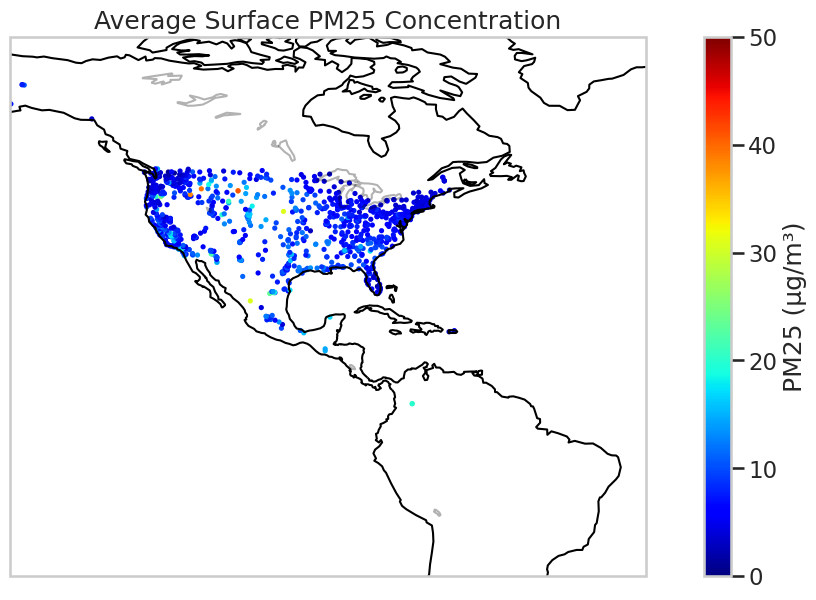

In [ ]:
# Calculate the maximum value for the colorbar, rounded up to the nearest 50
# This ensures the colorbar has a nice range and is visually appealing
max1 = ((df_avg.Value).max() // 50 + 1) * 50
unit = df_avg.Unit.unique()[0]

# Call the `plot_map` function to create the map visualization
# The `plot_map` function is defined earlier in the code and takes several arguments:
#   - `df_avg`: The DataFrame containing the data to plot (average pollutant values)
#   - `n_lat_min`, `n_lat_max`, `n_lon_min`, `n_lon_max`: Geographic boundaries for the map
#   - `my_cmap`: The colormap to use for the data points ('jet' in this case)
#   - `Colorbar_Label`: Label for the colorbar (includes pollutant name and unit)
#   - `Plot_Title`: Title of the map plot
#   - `Colorbar_Limits`: Range of values for the colorbar (0 to `max1`)
#   - `Point_Size`: Size of the data points on the map
#   - `Plot_Size`: Dimensions of the map plot (width, height)
plot = plot_map(df_avg,
               n_lat_min=lat_min,
               n_lat_max=lat_max,
               n_lon_min=lon_min,
               n_lon_max=lon_max,
               my_cmap=plt.cm.get_cmap('jet'),
               Colorbar_Label=f'{var.upper()} ({unit})',
               Plot_Title=f'Average Surface {var.upper()} Concentration',
               Colorbar_Limits=[0, max1],
               Point_Size=5,
               Plot_Size=[15, 7]
               )

# Save the generated map plot to a PNG file
# The filename includes the pollutant name, start date, and end date
# `data_path` is a variable defined earlier to specify the directory for saving files
plot.savefig(data_path + f'Avg_{var}_{start.strftime("%Y%m%d")}_{end.strftime("%Y%m%d")}.png')

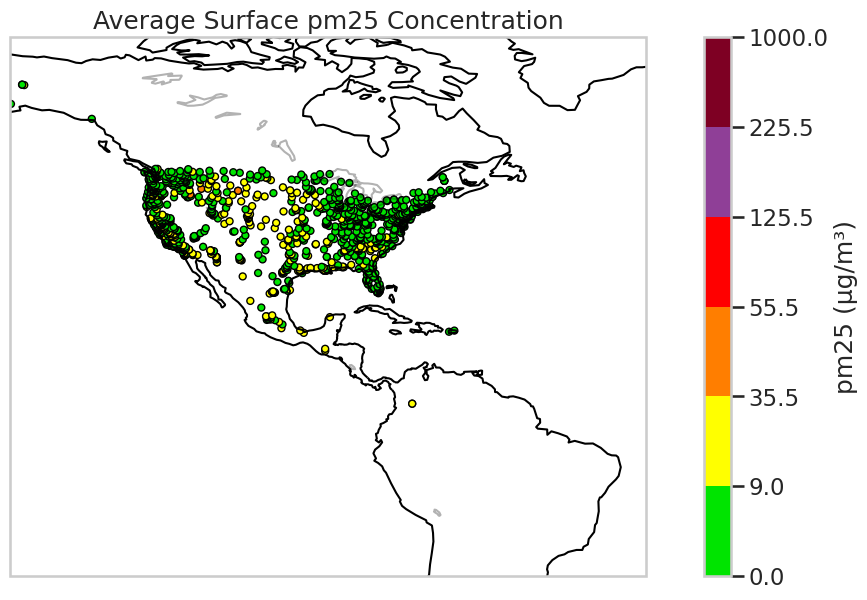

In [ ]:
# Plot Avg at all locations the data:
# This line is a comment, providing context for the code that follows.
# It indicates that the code below will plot the average pollutant values on a map.
df_avg = df_avg.dropna(subset=['Value'])
plot_AQI = plot_map_aqi(
    df_avg,  # The DataFrame containing the average pollutant values to be plotted.
    var.upper(),  # The pollutant type (e.g., 'PM25', 'PM10', 'OZONE').
    n_lat_min=lat_min,  # Minimum latitude for the map extent.
    n_lat_max=lat_max,  # Maximum latitude for the map extent.
    n_lon_min=lon_min,  # Minimum longitude for the map extent.
    n_lon_max=lon_max,  # Maximum longitude for the map extent.
    Colorbar_Label=f'{var} ({unit})',  # Label for the colorbar, showing pollutant and unit.
    Plot_Title=f'Average Surface {var} Concentration',  # Title of the plot.
    Colorbar_Limits=[0, 1000],  # Range of values for the colorbar.
    Point_Size=25,  # Size of the data points on the map.
    Plot_Size=[15, 7],  # Dimensions of the plot (width, height).
    discrete_levels=7  # Number of discrete levels for the colorbar (not used in this version).
)

# This line calls the `plot_map_aqi` function to create the map visualization.
# The function takes the data and various parameters to customize the map's appearance.
# The result of the function call (the map figure) is stored in the `EPA_AQI` variable.

plot_AQI.savefig(
    data_path + f'Avg_{var}_AQI_{start.strftime("%Y%m%d")}_{end.strftime("%Y%m%d")}.png'
)
# This line saves the generated map plot to a PNG file.

Input "D" for Daily or "H" for Hourly
d


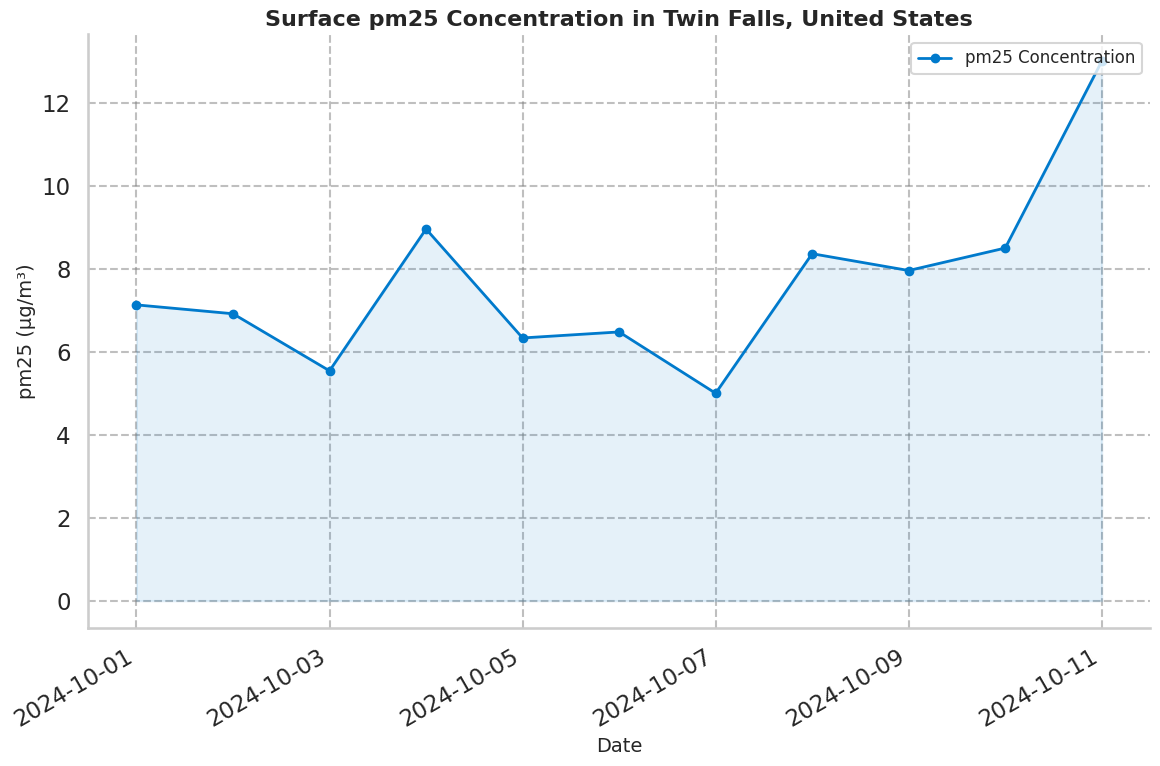

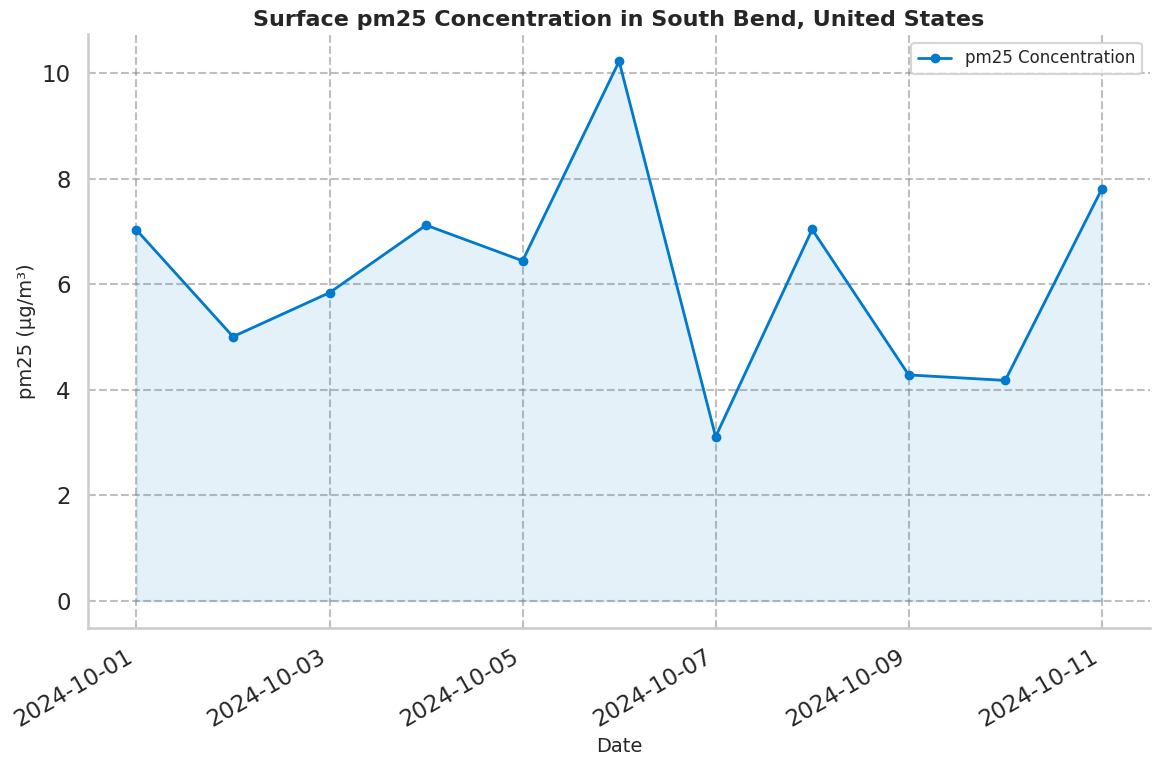

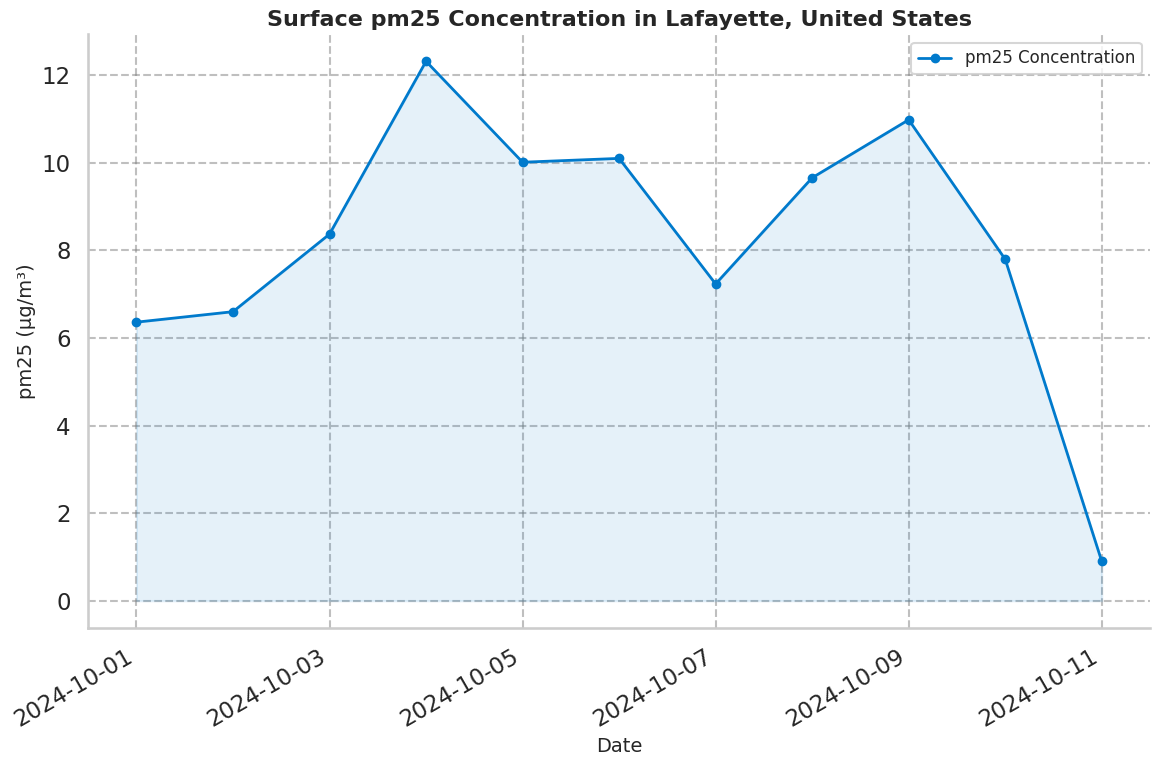

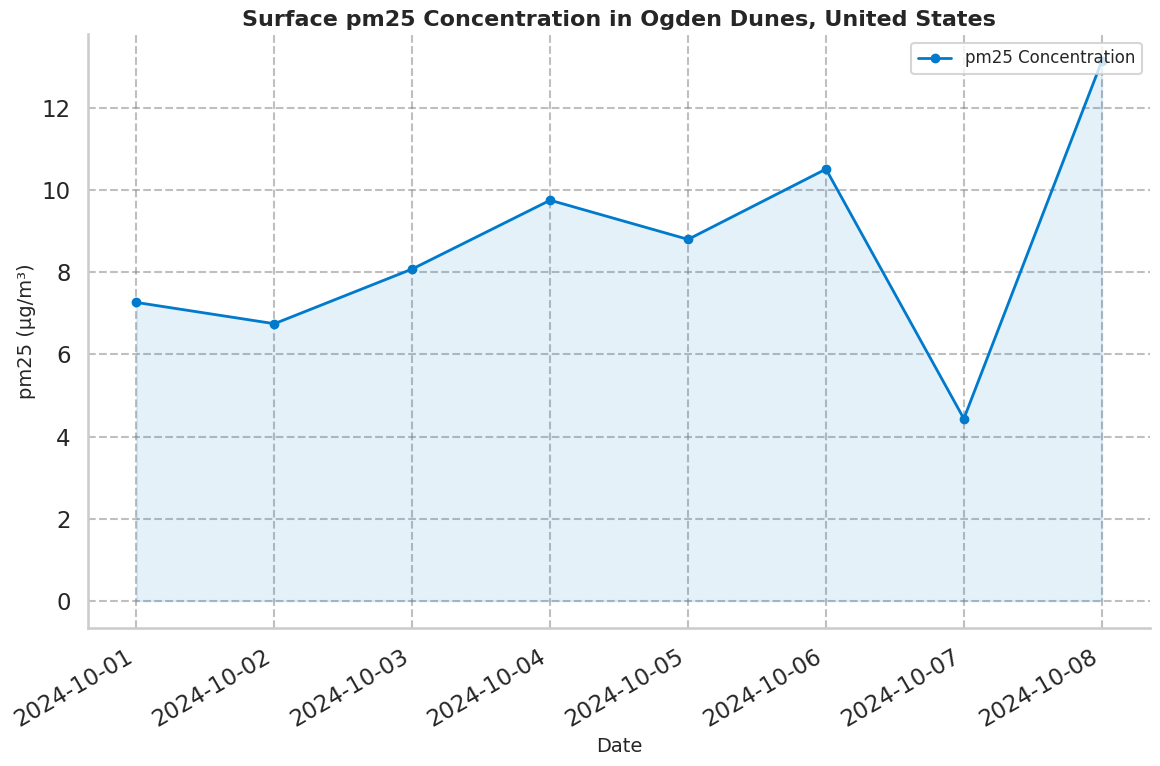

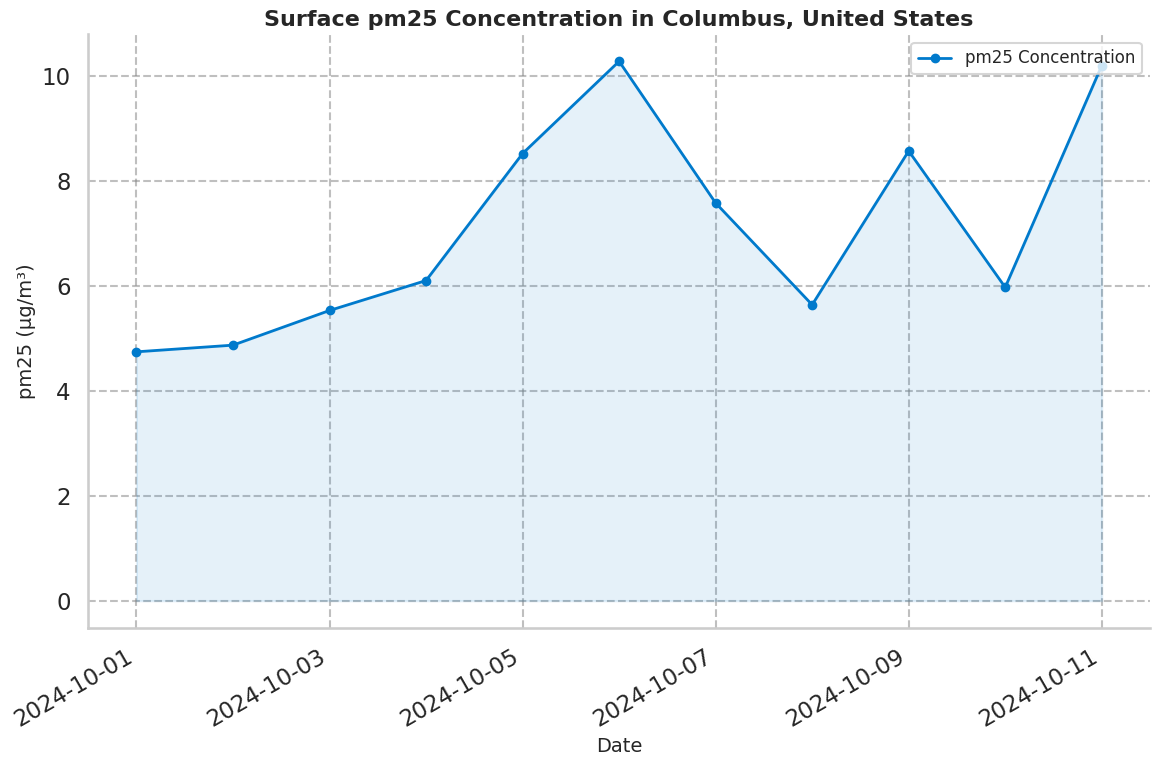

In [ ]:
# --- Code snippet for plotting individual location time series ---
# Ask user for daily or hourly data preference
daily = input('Input "D" for Daily or "H" for Hourly\n')
while daily not in ['D', 'H', 'd', "h"]:
    daily = input('Input "D" for Daily or "H" for Hourly\n')

locations = df[['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
# Loop through each unique location
for i in range(5):#len(locations)):
    # Get latitude and longitude of the current location
    lat = locations.loc[i, 'Latitude']
    lon = locations.loc[i, 'Longitude']

    # Filter data for the current location
    df_temp = df[(df.Latitude == lat) & (df.Longitude == lon)]

    # Get nearest city information (using a function defined elsewhere)
    df2 = get_nearest_city_df(df_temp[['Latitude', "Longitude"]].drop_duplicates())

    # Set 'UTC' column as index and select only 'Value' column
    df_temp.index = df_temp.Utc
    df_temp = df_temp[['Value']]

    # Resample data to daily or hourly averages based on user input
    if daily.upper() == 'D':  # Using upper() for case-insensitivity
        df_temp = df_temp.resample('D').mean()
    else:
        df_temp = df_temp.resample('H').mean()

    # --- Plotting ---

    # Apply Seaborn style for a more polished look
    sns.set_style("whitegrid")  # Use a whitegrid background
    sns.set_context("talk")  # Set context for larger font sizes



    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size

    # Plot the data as a line with markers
    ax.plot(df_temp.index, df_temp['Value'], marker='o', linestyle='-',
            color='#007acc', linewidth=2, markersize=6,
            label=f'{var} Concentration')  # Added a label and custom color

    # Set plot title, including city and country information
    ax.set_title(f'Surface {var} Concentration in {df2.Nearest_City.iloc[0]}, {df2.Country.iloc[0]}',
                 fontsize=16, fontweight='bold')  # Increased title size and weight

    # Set x and y axis labels with improved formatting
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel(f'{var} ({unit})', fontsize=14)

    # Format x-axis ticks for date display with better spacing
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))  # Limit number of ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()  # Rotate x-axis labels

    # Add gridlines with customization
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')  # Lighter gridlines

    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a legend for better clarity
    ax.legend(fontsize=12, loc='upper right')

    # Add a subtle background shading
    ax.fill_between(df_temp.index, df_temp['Value'], color='#007acc', alpha=0.1)

    # Add annotations for minimum and maximum values
    min_val = df_temp['Value'].min()
    max_val = df_temp['Value'].max()
    min_idx = df_temp['Value'].idxmin()
    max_idx = df_temp['Value'].idxmax()


    # Display the plot
    plt.tight_layout()
    plt.show()